In [1]:
import os, sys
import math
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from xgboost import XGBRegressor

import tensorflow as tf
from tensorflow import keras

### Hardware Check

In [2]:
 print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Files Available

In [3]:
[file for file in os.listdir() if file.endswith('.csv')]

['holidays_events.csv',
 'oil.csv',
 'sample_submission.csv',
 'stores.csv',
 'test.csv',
 'train.csv',
 'transactions.csv']

In [4]:
transactions_df = pd.read_csv('transactions.csv')

### Oil vs. Transaction Volume Correlation

In [5]:
oil_df = pd.read_csv('oil.csv')
oil_df = oil_df.interpolate(method ='linear', limit_direction ='forward')

C:\Users\bcros\AppData\Local\Temp\ipykernel_20824\966037693.py:2: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  oil_df = oil_df.interpolate(method ='linear', limit_direction ='forward')


In [6]:
oil_df[oil_df.dcoilwtico.isna()]

,date,dcoilwtico
0,2013-01-01,NaN


<Axes: xlabel='date'>

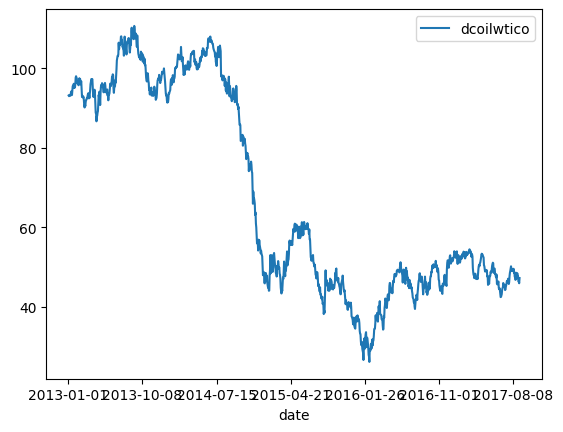

In [7]:
oil_df.set_index('date').plot()

In [8]:
transactions_df = pd.merge(transactions_df, oil_df, on='date')

In [9]:
transactions_df = transactions_df.dropna()

In [10]:
transactions_by_oil = transactions_df.groupby(by=['date']).agg({"transactions": 'sum', "dcoilwtico": 'max'})

<Axes: xlabel='transactions', ylabel='dcoilwtico'>

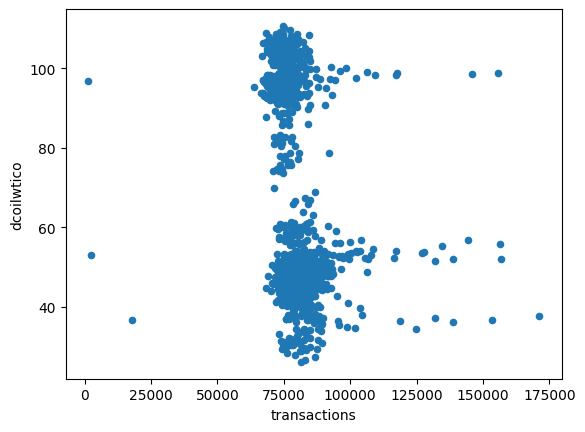

In [11]:
transactions_by_oil.reset_index().plot.scatter(x='transactions', y='dcoilwtico')

<Axes: xlabel='dcoilwtico', ylabel='transactions'>

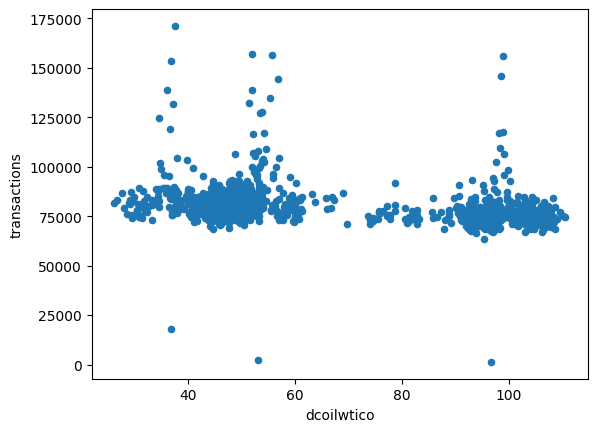

In [19]:
transactions_by_oil.reset_index().plot.scatter(x='dcoilwtico', y='transactions')

In [12]:
transactions_by_oil.reset_index()

,date,transactions,dcoilwtico
0,2013-01-02,93215,93.14
1,2013-01-03,78504,92.97
2,2013-01-04,78494,93.12
3,2013-01-07,75597,93.20
4,2013-01-08,72325,93.21
...,...,...,...
1196,2017-08-09,85452,49.59
1197,2017-08-10,83064,48.54
1198,2017-08-11,89551,48.81
1199,2017-08-14,85448,47.59


In [13]:
def normalize_column(df, column):
    max_col = df[column].max()
    min_col = df[column].min()
    new_col = f"{column}_normal"
    df[new_col] = df[column].apply(lambda x: (x - min_col)/(max_col - min_col))
    return df

In [14]:
transactions_by_oil = normalize_column(transactions_by_oil, 'transactions')
transactions_by_oil = normalize_column(transactions_by_oil, 'dcoilwtico')

In [15]:
transactions_by_oil

,transactions,dcoilwtico,transactions_normal,dcoilwtico_normal
date,,,,
2013-01-02,93215,93.14,0.541020,0.792965
2013-01-03,78504,92.97,0.454405,0.790951
2013-01-04,78494,93.12,0.454346,0.792728
2013-01-07,75597,93.20,0.437289,0.793675
2013-01-08,72325,93.21,0.418024,0.793794
...,...,...,...,...
2017-08-09,85452,49.59,0.495313,0.277153
2017-08-10,83064,48.54,0.481253,0.264716
2017-08-11,89551,48.81,0.519447,0.267914


In [16]:
x = transactions_by_oil.index.to_list()
y1 = transactions_by_oil['transactions_normal'].to_list()
y2 = transactions_by_oil['dcoilwtico_normal'].to_list()

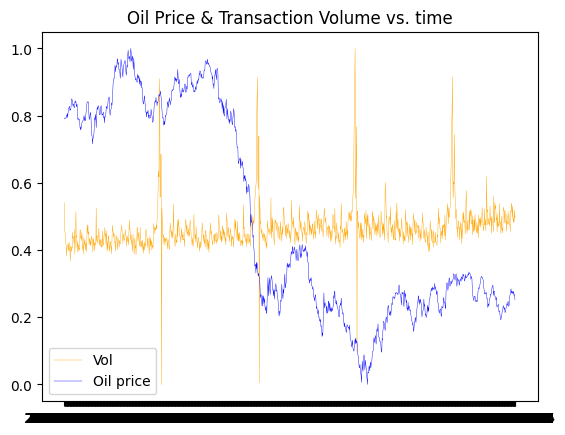

In [17]:
plt.plot(x, y1, color='orange', label='Vol', linewidth=0.3)
plt.plot(x, y2, color='b', label='Oil price', linewidth=0.3)
plt.title('Oil Price & Transaction Volume vs. time')
plt.legend()
plt.show()

### Weekday Volume

In [17]:
# del transactions_df['dcoilwtico']

In [28]:
# remove holidays
holiday_df = pd.read_csv('holidays_events.csv')
holidays = holiday_df.date.to_list()
transactions_df['is_holiday'] = transactions_df.date.apply(lambda x: True if x in holidays else False)

In [29]:
transactions_by_DOW = transactions_df[~transactions_df.is_holiday].groupby(by='date').agg({'transactions': 'sum'}).reset_index()

In [30]:
transactions_by_DOW

,date,transactions
0,2013-01-02,93215
1,2013-01-03,78504
2,2013-01-04,78494
3,2013-01-06,90464
4,2013-01-07,75597
...,...,...
1426,2017-08-08,83422
1427,2017-08-09,85452
1428,2017-08-12,89927
1429,2017-08-13,85993


In [24]:
days_of_week = ['tues', 'wed', 'thurs', 'fri', 'sat', 'sun', 'mon']
date_min = transactions_df.date.min()
date_max = transactions_df.date.max()
day_range = datetime.strptime(date_max, '%Y-%m-%d') - datetime.strptime(date_min, '%Y-%m-%d')
date_total = []
for i in range(day_range.days + 1):
    date_total.append((datetime.strptime(date_min, '%Y-%m-%d') + timedelta(days=i)).strftime('%Y-%m-%d'))
ndx_dates = enumerate(date_total)
invert_ndx_dates = {}
for k, v in ndx_dates:
    invert_ndx_dates[v] = days_of_week[(k % 7)]

In [25]:
invert_ndx_dates

{'2013-01-02': 'tues',
 '2013-01-03': 'wed',
 '2013-01-04': 'thurs',
 '2013-01-05': 'fri',
 '2013-01-06': 'sat',
 '2013-01-07': 'sun',
 '2013-01-08': 'mon',
 '2013-01-09': 'tues',
 '2013-01-10': 'wed',
 '2013-01-11': 'thurs',
 '2013-01-12': 'fri',
 '2013-01-13': 'sat',
 '2013-01-14': 'sun',
 '2013-01-15': 'mon',
 '2013-01-16': 'tues',
 '2013-01-17': 'wed',
 '2013-01-18': 'thurs',
 '2013-01-19': 'fri',
 '2013-01-20': 'sat',
 '2013-01-21': 'sun',
 '2013-01-22': 'mon',
 '2013-01-23': 'tues',
 '2013-01-24': 'wed',
 '2013-01-25': 'thurs',
 '2013-01-26': 'fri',
 '2013-01-27': 'sat',
 '2013-01-28': 'sun',
 '2013-01-29': 'mon',
 '2013-01-30': 'tues',
 '2013-01-31': 'wed',
 '2013-02-01': 'thurs',
 '2013-02-02': 'fri',
 '2013-02-03': 'sat',
 '2013-02-04': 'sun',
 '2013-02-05': 'mon',
 '2013-02-06': 'tues',
 '2013-02-07': 'wed',
 '2013-02-08': 'thurs',
 '2013-02-09': 'fri',
 '2013-02-10': 'sat',
 '2013-02-11': 'sun',
 '2013-02-12': 'mon',
 '2013-02-13': 'tues',
 '2013-02-14': 'wed',
 '2013-02-15'

In [76]:
transactions_by_DOW['day_of_week'] = transactions_by_DOW['date'].apply(lambda x: invert_ndx_dates[x])

In [77]:
transactions_by_DOW

,date,transactions,day_of_week
0,2013-01-02,93215,wed
1,2013-01-03,78504,thurs
2,2013-01-04,78494,fri
3,2013-01-06,90464,sun
4,2013-01-07,75597,mon
...,...,...,...
1426,2017-08-08,83422,tues
1427,2017-08-09,85452,wed
1428,2017-08-12,89927,sat
1429,2017-08-13,85993,sun


In [79]:
mon = transactions_by_DOW[transactions_by_DOW.day_of_week == 'mon'].transactions.to_list()
tues = transactions_by_DOW[transactions_by_DOW.day_of_week == 'tues'].transactions.to_list()
wed = transactions_by_DOW[transactions_by_DOW.day_of_week == 'wed'].transactions.to_list()
thurs = transactions_by_DOW[transactions_by_DOW.day_of_week == 'thurs'].transactions.to_list()
fri = transactions_by_DOW[transactions_by_DOW.day_of_week == 'fri'].transactions.to_list()
sat = transactions_by_DOW[transactions_by_DOW.day_of_week == 'sat'].transactions.to_list()
sun = transactions_by_DOW[transactions_by_DOW.day_of_week == 'sun'].transactions.to_list()

x = range(min(len(mon), len(tues), len(wed), len(thurs), len(fri), len(sat), len(sun)))

In [80]:
len(x)

197

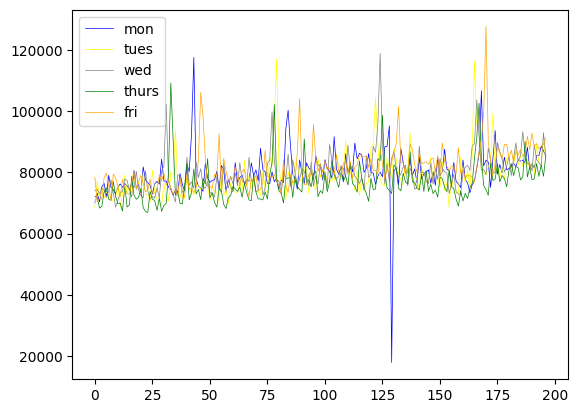

In [88]:
plt.plot(x, mon[(len(mon)-len(x)):], color='b', linewidth=0.5, label='mon')
plt.plot(x, tues[(len(tues)-len(x)):], color='yellow', linewidth=0.5, label='tues')
plt.plot(x, wed[(len(wed)-len(x)):], color='grey', linewidth=0.5, label='wed')
plt.plot(x, thurs[(len(thurs)-len(x)):], color='g', linewidth=0.5, label='thurs')
plt.plot(x, fri[(len(fri)-len(x)):], color='orange', linewidth=0.5, label='fri')
plt.legend()
plt.show()

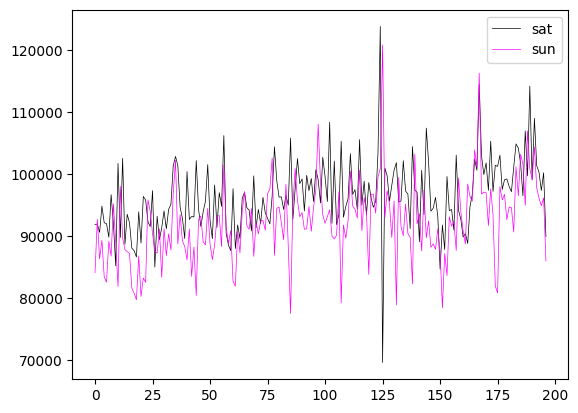

In [89]:
plt.plot(x, sat[(len(sat)-len(x)):], color='black', linewidth=0.5, label='sat')
plt.plot(x, sun[(len(sun)-len(x)):], color='magenta', linewidth=0.5, label='sun')
plt.legend()
plt.show()

In [90]:
count = 0
unfold_data = []
for rw in transactions_by_DOW.index:
    old_row = transactions_by_DOW.iloc[rw].to_dict()
    print(old_row)
    day = old_row['day_of_week']

    if day == 'wed':
        new_row = {'id': count}
    
    new_row[day] = old_row['transactions']
        
    if day == 'tues':
        unfold_data.append(new_row)
        count += 1

{'date': '2013-01-02', 'transactions': 93215, 'day_of_week': 'wed'}
{'date': '2013-01-03', 'transactions': 78504, 'day_of_week': 'thurs'}
{'date': '2013-01-04', 'transactions': 78494, 'day_of_week': 'fri'}
{'date': '2013-01-06', 'transactions': 90464, 'day_of_week': 'sun'}
{'date': '2013-01-07', 'transactions': 75597, 'day_of_week': 'mon'}
{'date': '2013-01-08', 'transactions': 72325, 'day_of_week': 'tues'}
{'date': '2013-01-09', 'transactions': 71971, 'day_of_week': 'wed'}
{'date': '2013-01-10', 'transactions': 66383, 'day_of_week': 'thurs'}
{'date': '2013-01-11', 'transactions': 70338, 'day_of_week': 'fri'}
{'date': '2013-01-13', 'transactions': 86306, 'day_of_week': 'sun'}
{'date': '2013-01-14', 'transactions': 70078, 'day_of_week': 'mon'}
{'date': '2013-01-15', 'transactions': 71134, 'day_of_week': 'tues'}
{'date': '2013-01-16', 'transactions': 72471, 'day_of_week': 'wed'}
{'date': '2013-01-17', 'transactions': 68873, 'day_of_week': 'thurs'}
{'date': '2013-01-18', 'transactions': 7

In [91]:
unfold_df = pd.DataFrame(unfold_data)
del unfold_df['id']

In [92]:
unfold_df

,wed,thurs,fri,sun,mon,tues,sat
0,93215,78504.0,78494.0,90464.0,75597.0,72325,NaN
1,71971,66383.0,70338.0,86306.0,70078.0,71134,NaN
2,72471,68873.0,71371.0,85281.0,73250.0,68988,88558.0
3,69819,63705.0,71273.0,83304.0,70389.0,68435,88022.0
4,70888,70268.0,78302.0,87026.0,75330.0,76206,97347.0
...,...,...,...,...,...,...,...
202,80551,77922.0,88368.0,104392.0,NaN,89109,108993.0
203,89085,82927.0,89467.0,97757.0,85547.0,83071,101349.0
204,84155,78720.0,87671.0,96119.0,85477.0,82267,100293.0
205,82113,78743.0,89197.0,94899.0,88593.0,92083,100227.0


In [93]:
unfold_df.describe()

,wed,thurs,fri,sun,mon,tues,sat
count,207.000000,194.000000,183.000000,187.000000,188.000000,207.000000,184.000000
mean,79627.304348,76137.288660,81229.792350,92070.320856,79791.856383,78105.855072,95973.472826
std,6635.326123,6373.304546,6965.208641,6358.516926,7150.960880,6126.895895,6163.194143
min,69819.000000,63705.000000,70338.000000,77449.000000,17829.000000,68435.000000,69628.000000
25%,74979.000000,71899.500000,76898.500000,88340.500000,76301.500000,73627.000000,92132.000000
50%,78534.000000,74817.000000,79604.000000,92139.000000,79593.500000,76983.000000,95552.500000
75%,82571.000000,78735.000000,84523.000000,95790.000000,83121.000000,81241.000000,99702.500000
max,118947.000000,102665.000000,127771.000000,116289.000000,106760.000000,104623.000000,123810.000000


### Anomaly Days

In [166]:
holiday_df = pd.read_csv('holidays_events.csv')
holiday_df[(holiday_df.type == 'Transfer') | (holiday_df.transferred)]

,date,type,locale,locale_name,description,transferred
19,2012-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
20,2012-10-12,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False
72,2013-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
73,2013-10-11,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False
135,2014-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
136,2014-10-10,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False
255,2016-05-24,Holiday,National,Ecuador,Batalla de Pichincha,True
256,2016-05-27,Transfer,National,Ecuador,Traslado Batalla de Pichincha,False
265,2016-07-24,Transfer,Local,Guayaquil,Traslado Fundacion de Guayaquil,False
266,2016-07-25,Holiday,Local,Guayaquil,Fundacion de Guayaquil,True


In [94]:
holidays = holiday_df.date.to_list()
# transactions_df['is_holiday'] = transactions_df.date.apply(lambda x: True if x in holidays else False)

In [175]:
# transactions_filter_holiday = transactions_df[~transactions_df.is_holiday].reset_index(drop=True)
# del transactions_filter_holiday['is_holiday']

In [113]:
# tfh = transactions_filter_holiday.groupby(by='date').agg({'transactions': 'sum'}).reset_index()
tfg = transactions_df.groupby(by='date').agg({'transactions': 'sum'}).reset_index()
tfg['is_holiday'] = tfg.date.apply(lambda x: True if x in holidays else False)
tfg['day_of_week'] = tfg.date.apply(lambda x: invert_ndx_dates[x])
tfg['weekend'] = tfg.day_of_week.apply(lambda x: True if x in ['sat', 'sun'] else False)

In [114]:
tfg[tfg.transactions > tfg.transactions.quantile(0.9)]

,date,transactions,is_holiday,day_of_week,weekend
60,2013-03-02,98616,True,sat,True
130,2013-05-11,111484,True,sat,True
151,2013-06-01,101740,False,sat,True
152,2013-06-02,98018,False,sun,True
165,2013-06-15,102541,False,sat,True
...,...,...,...,...,...
1643,2017-07-08,101349,False,sat,True
1644,2017-07-09,97757,False,sun,True
1650,2017-07-15,100293,False,sat,True
1664,2017-07-29,100227,False,sat,True


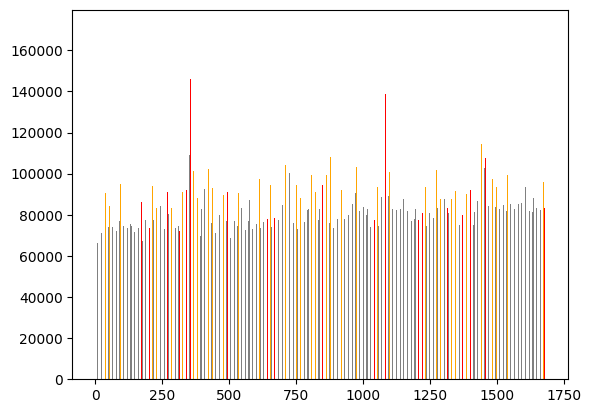

In [135]:
y = tfg.transactions.to_list()
x = range(len(y))
colors = []
for rw in tfg.index:
    row_data = tfg.iloc[rw].to_dict()
    is_holiday = row_data['is_holiday']
    is_weekend = row_data['weekend']
    if is_holiday:
        colors.append('red')
    elif is_weekend:
        colors.append('orange')
    else:
        colors.append('grey')
    
plt.bar(x, y, width=0.35, color=colors)
plt.show()

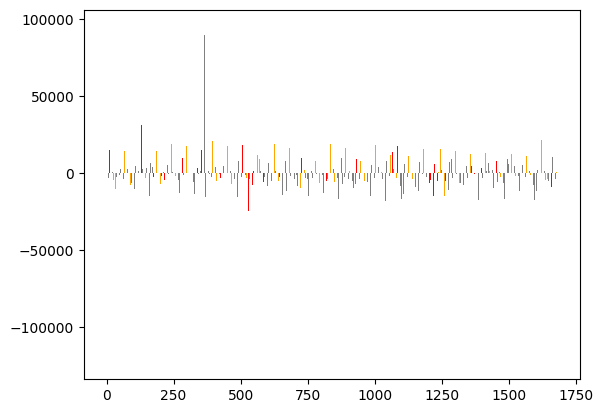

In [155]:
deltas = [0, 0]
for i in range(2, len(y)):
    delta = y[i] - y[i-1]
    deltas.append(delta)

plt.bar(x, deltas, width=0.5, color=colors)
plt.ylim(top=max(deltas), bottom=min(deltas))
plt.show()

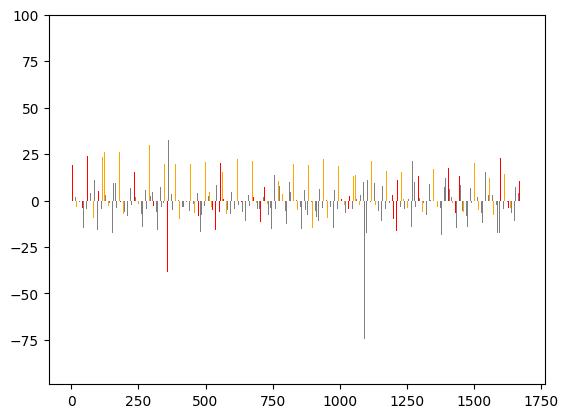

In [163]:
pct_changes = [0, 0]
for i in range(2, len(y)):
    pct_change = (100 * (y[i] - y[i-1])) / y[i-1]
    pct_changes.append(round(pct_change, 2))
plt.bar(x, pct_changes, width=0.5, color=colors)
plt.ylim(top=100, bottom=min(pct_changes))
plt.show()

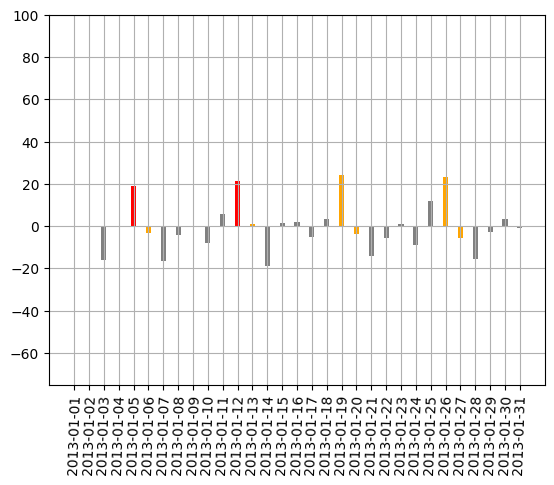

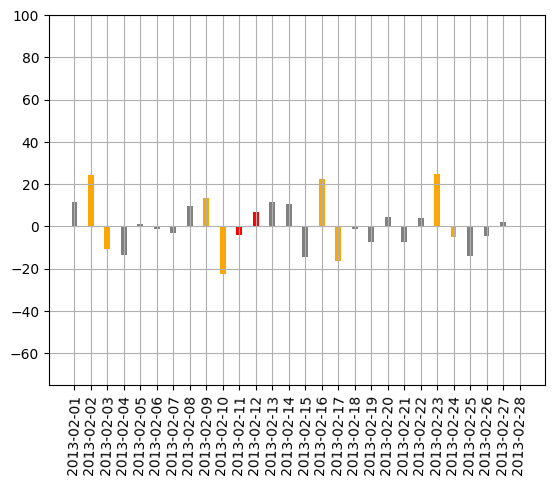

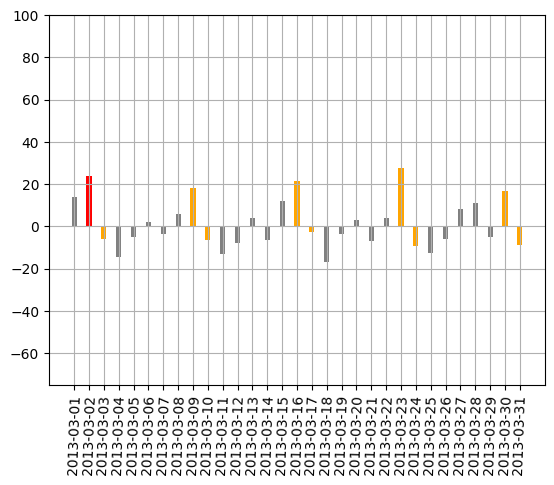

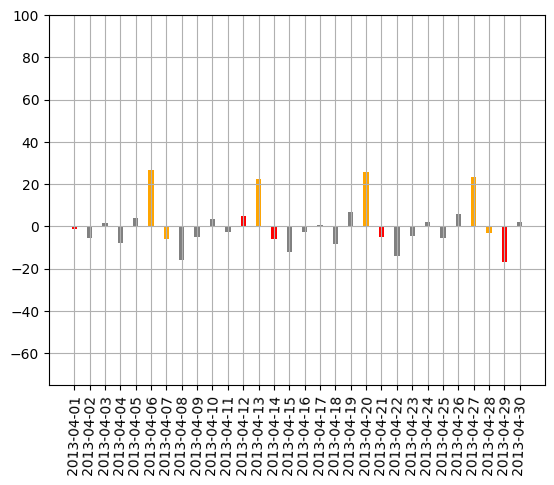

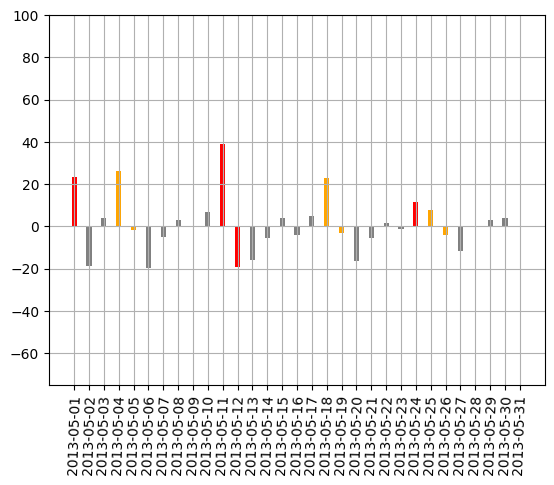

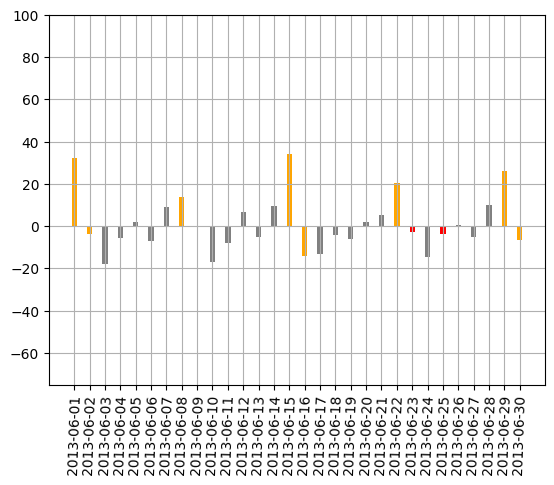

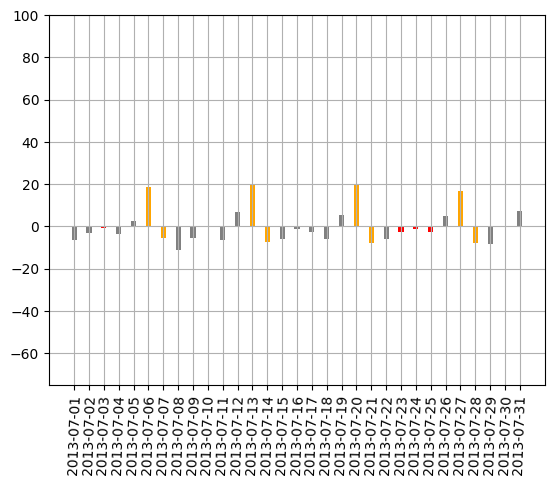

In [181]:
month_days = {0: 31, 31: 59, 59: 90, 90: 120, 120: 151, 151: 181, 181: 212}
for start_d, end_d in month_days.items(): 
    plt.bar(tfg.date.to_list()[start_d:end_d], pct_changes[start_d:end_d], color=colors[start_d:end_d], width=0.35)
    plt.xticks(rotation=88)
    plt.ylim(top=100, bottom=-75)
    plt.grid()
    plt.show()

### Time of Month

In [22]:
tfh['day_of_month'] = tfh.date.apply(lambda x: x.split('-')[2])

NameError: name 'tfh' is not defined

In [225]:
tfh_day_of_month = tfh.groupby(by='day_of_month').agg({'transactions': 'mean'}).reset_index()
tfh_day_of_month = normalize_column(tfh_day_of_month, 'transactions')

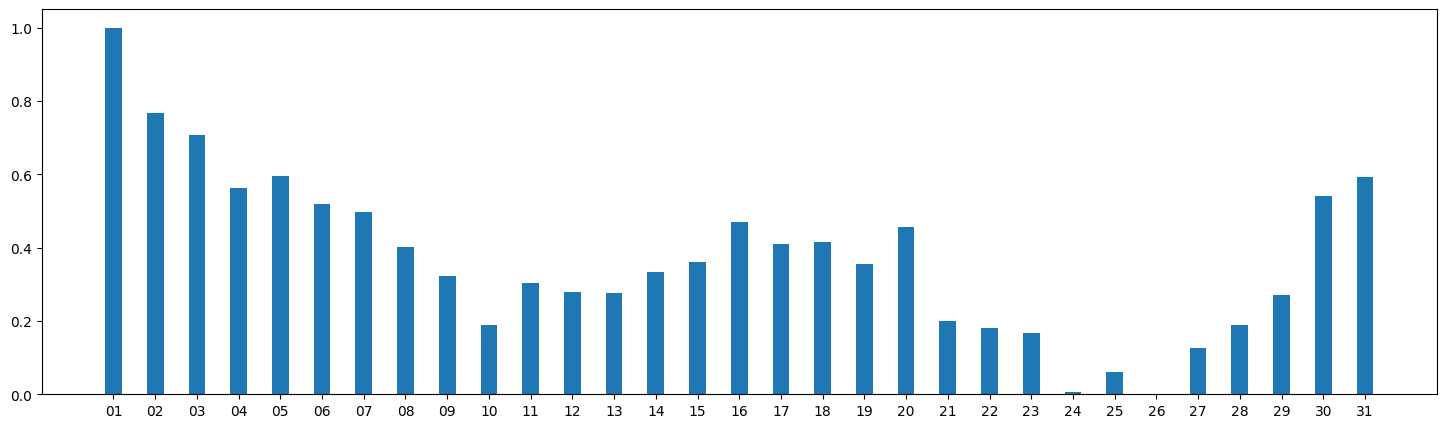

In [227]:
y_tdom = tfh_day_of_month.transactions_normal.to_list()
x_tdom = tfh_day_of_month.day_of_month.to_list()
f, ax = plt.subplots(figsize=(18,5))
ax.bar(x_tdom, y_tdom, width=0.4)
plt.show()

### Store Performance

In [26]:
transactions_df['weekend'] = transactions_df['date'].apply(lambda x: True if invert_ndx_dates[x] in ['sat', 'sun'] else False)
transactions_df['year_month'] = transactions_df['date'].apply(lambda x: '-'.join(x.split('-')[0:2]))

In [27]:
moving_avg_chunk = 20
avg_20_day = []
for str_nbr in transactions_df.store_nbr.drop_duplicates().to_list():
    store_transaction_df = transactions_df[transactions_df.store_nbr == str_nbr].reset_index(drop=True)
    
    for i in range(moving_avg_chunk, len(transactions_df)):
        original_row = store_transactions_df.iloc[i].to_dict()
        if i < moving_avg_chunk:
            i_m = 0
        else:
            i_m = i 
        

    

,date,store_nbr,transactions,dcoilwtico,weekend,year_month
1,2013-01-02,1,2111,93.14,False,2013-01
2,2013-01-02,2,2358,93.14,False,2013-01
3,2013-01-02,3,3487,93.14,False,2013-01
4,2013-01-02,4,1922,93.14,False,2013-01
5,2013-01-02,5,1903,93.14,False,2013-01
...,...,...,...,...,...,...
59646,2017-08-15,50,2804,47.57,False,2017-08
59647,2017-08-15,51,1573,47.57,False,2017-08
59648,2017-08-15,52,2255,47.57,False,2017-08
59649,2017-08-15,53,932,47.57,False,2017-08


In [34]:
transactions_df.loc[0:20, 'transactions'].mean()

2002.4

In [28]:
store_df = (
    transactions_df
    .groupby(by=['store_nbr', 'year_month'])
    .agg({'transactions': 'sum', 'store_nbr': 'count'})
    .unstack(['store_nbr', 'year_month'])
)

In [29]:
store_df

              store_nbr  year_month
transactions  1          2013-01       39694
                         2013-02       33579
                         2013-03       36391
                         2013-04       39336
                         2013-05       39050
                                       ...  
store_nbr     54         2017-04          20
                         2017-05          23
                         2017-06          22
                         2017-07          21
                         2017-08          11
Length: 5602, dtype: int64

In [127]:
for month in store_df.index:
    print(store_df.loc[month])

47471
40587
45299
46740
46286
44876
47874
45789
44540
46424
46783
50110
47417
43819
44311
46035
47225
45680
48253
46066
46414
46535
43037
53532
47302
41473
47794
46139
46838
47870
47190
44656
46182
45835
42896
54431
41572
42653
46244
46771
45385
45609
45258
44915
44899
45625
43241
52090
45441
40868
48530
43396
45426
47479
47457
21395
57588
51269
56849
55188
56738
55607
56987
57410
56673
57008
57708
68879
58314
53874
59796
58824
59082
57406
58996
59066
58749
59514
58100
69772
58896
53448
59999
57845
60528
58390
58958
57217
57272
58322
56766
70559
52399
55121
58276
59522
59266
56943
56526
55188
55964
57482
55399
68596
56937
52210
58156
55946
57974
56489
57316
26594
90946
83135
95882
91557
94211
94855
95384
96323
95199
95357
93539
115043
94319
87848
98134
97023
100083
95728
95806
95886
95360
96707
93296
115946
95023
85745
97799
94630
100531
95430
98264
98698
95264
97700
97133
119050
86542
91944
97990
97694
98419
93099
96550
94323
93278
98002
95564
120803
96430
88566
97419
97404
98717
9555

### Training Data

In [228]:
train_df = pd.read_csv('train.csv')

### Sample Hybrid Model

In [62]:
y_train, y_valid = y[:"2017-07-01"], y["2017-07-02":]
X1_train, X1_valid = X_1[: "2017-07-01"], X_1["2017-07-02" :]
X2_train, X2_valid = X_2.loc[:"2017-07-01"], X_2.loc["2017-07-02":]

# Some of the algorithms above do best with certain kinds of
# preprocessing on the features (like standardization), but this is
# just a demo.
model.fit(X1_train, X2_train, y_train)
y_fit = model.predict(X1_train, X2_train).clip(0.0)
y_pred = model.predict(X1_valid, X2_valid).clip(0.0)

families = y.columns[0:6]
axs = y.loc(axis=1)[families].plot(
    subplots=True, sharex=True, figsize=(11, 9), alpha=0.5, marker=".", color="grey", linewidth=0.3, grid="minor"
)
_ = y_fit.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C0', ax=axs, linewidth=0.3)
_ = y_pred.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C3', ax=axs, linewidth=0.4)
for ax, family in zip(axs, families):
    ax.legend([])
    ax.set_ylabel(family)

TypeError: slice indices must be integers or None or have an __index__ method

In [14]:
transactions_df = pd.merge(transactions_df, oil_df, on='date')

In [101]:
store_sales = pd.read_csv('train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)

C:\Users\bcros\AppData\Local\Temp\ipykernel_5136\1316617746.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  store_sales = pd.read_csv('train.csv',


In [102]:
store_sales[store_sales['store_nbr'] == '1']

,date,store_nbr,family,sales,onpromotion
0,2013-01-01,1,AUTOMOTIVE,0.000000,0
1,2013-01-01,1,BABY CARE,0.000000,0
2,2013-01-01,1,BEAUTY,0.000000,0
3,2013-01-01,1,BEVERAGES,0.000000,0
4,2013-01-01,1,BOOKS,0.000000,0
...,...,...,...,...,...
2999134,2017-08-15,1,POULTRY,234.891998,0
2999135,2017-08-15,1,PREPARED FOODS,42.822998,0
2999136,2017-08-15,1,PRODUCE,2240.229980,7
2999137,2017-08-15,1,SCHOOL AND OFFICE SUPPLIES,0.000000,0


In [103]:
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()

In [121]:
family_sales = (
    store_sales
    .groupby(['family', 'date'])
    .mean()
    .unstack('family')
    .loc['2017']
)

C:\Users\bcros\AppData\Local\Temp\ipykernel_5136\3347952759.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['family', 'date'])


In [122]:
y = family_sales.loc[:, 'sales']

In [123]:
# Features for Linear Regression
dp = DeterministicProcess(index=y.index, order=1)
X_1 = dp.in_sample()

In [124]:
# X_2: Features for XGBoost
X_2 = family_sales.drop('sales', axis=1).stack()  # onpromotion feature

In [125]:
X_2

onpromotion
date       family                                 
2017-01-01 AUTOMOTIVE                     0.000000
           BABY CARE                      0.000000
           BEAUTY                         0.000000
           BEVERAGES                      0.703704
           BOOKS                          0.000000
...                                            ...
2017-08-15 POULTRY                        0.111111
           PREPARED FOODS                 0.166667
           PRODUCE                       58.685185
           SCHOOL AND OFFICE SUPPLIES     2.740741
           SEAFOOD                        0.000000

[7491 rows x 1 columns]

In [126]:
# Label encoding for 'family'
le = LabelEncoder()  # from sklearn.preprocessing

In [127]:
# Set Family 
X_2 = X_2.reset_index('family')

In [128]:
# Apply fit transform
X_2['family'] = le.fit_transform(X_2['family'])

In [132]:
# Label encoding for seasonality
X_2["day"] = X_2.index.day  # values are day of the month

In [58]:
# You'll add fit and predict methods to this minimal class
class BoostedHybrid:
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_columns = None  # store column names from fit method
        
def fit(self, X_1, X_2, y):
    # YOUR CODE HERE: fit self.model_1
    self.model_1.fit(X_1, y)

    y_fit = pd.DataFrame(
        # YOUR CODE HERE: make predictions with self.model_1
        self.model_1.predict(X_1),
        index=X_1.index, columns=y.columns,
    )

    # YOUR CODE HERE: compute residuals
    y_resid = y - y_fit
    y_resid = y_resid.stack().squeeze() # wide to long

    # YOUR CODE HERE: fit self.model_2 on residuals
    self.model_2.fit(X_2, y_resid)

    # Save column names for predict method
    self.y_columns = y.columns
    # Save data for question checking
    self.y_fit = y_fit
    self.y_resid = y_resid

In [133]:
# Add method to class
BoostedHybrid.fit = fit


In [134]:
def predict(self, X_1, X_2):
    y_pred = pd.DataFrame(
        # YOUR CODE HERE: predict with self.model_1
        data=self.model_1.predict(X_1),
        index=X_1.index,
        columns=self.y_columns
    )
    y_pred = y_pred.stack().squeeze()  # wide to long

    # YOUR CODE HERE: add self.model_2 predictions to y_pred
    y_pred += self.model_2.predict(X_2)
    
    return y_pred.unstack()  # long to wide

In [135]:
# Add method to class
BoostedHybrid.predict = predict

In [136]:
# YOUR CODE HERE: Create LinearRegression + XGBRegressor hybrid with BoostedHybrid
model = BoostedHybrid(model_1=LinearRegression(), model_2=XGBRegressor())

# YOUR CODE HERE: Fit and predict
model.fit(X_1, X_2, y)
y_pred = model.predict(X_1, X_2)
y_pred = y_pred.clip(0.0)

In [151]:
def rmsle_log_part(y_hat, y):
    left = math.log(1+y_hat)
    right = math.log(1+y)
    return (left - right)**2

In [164]:
# y["2017-07-02" :].loc(axis=1)['AUTOMOTIVE']

In [165]:
# y_pred.loc(axis=1)['AUTOMOTIVE']

In [158]:
measured = pd.merge(y["2017-07-02":], y_pred, on='date')

In [178]:
for fam in families:
    print(fam)
    y_hat = f"{fam}_y"
    y = f"{fam}_x"
    list_col = [y_hat, y]
    sub_df = measured[list_col]
    sub_df['error_part'] = sub_df[list_col].apply(lambda x: rmsle_log_part(x[0], x[1]), axis=1)
    sum_error_part = sub_df['error_part'].sum()
    avg_error_part = sum_error_part / len(sub_df)
    rmsle = avg_error_part ** 0.5
    print("RMSLE:", round(rmsle, 3))
    print()

AUTOMOTIVE
RMSLE: 0.449

BABY CARE
RMSLE: 0.804

BEAUTY
RMSLE: 1.239

BEVERAGES
RMSLE: 0.224

BOOKS
RMSLE: 0.734

BREAD/BAKERY
RMSLE: 0.221



C:\Users\bcros\AppData\Local\Temp\ipykernel_5136\718996918.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sub_df['error_part'] = sub_df[list_col].apply(lambda x: rmsle_log_part(x[0], x[1]), axis=1)
C:\Users\bcros\AppData\Local\Temp\ipykernel_5136\718996918.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['error_part'] = sub_df[list_col].apply(lambda x: rmsle_log_part(x[0], x[1]), axis=1)
C:\Users\bcros\AppData\Local\Temp\ipykernel_5136\718996918.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, 

C:\Users\bcros\AppData\Local\Temp\ipykernel_5136\1010965008.py:16: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  _ = y_fit.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C0', ax=axs, linewidth=0.3)
C:\Users\bcros\AppData\Local\Temp\ipykernel_5136\1010965008.py:17: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  _ = y_pred.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C3', ax=axs, linewidth=0.4)


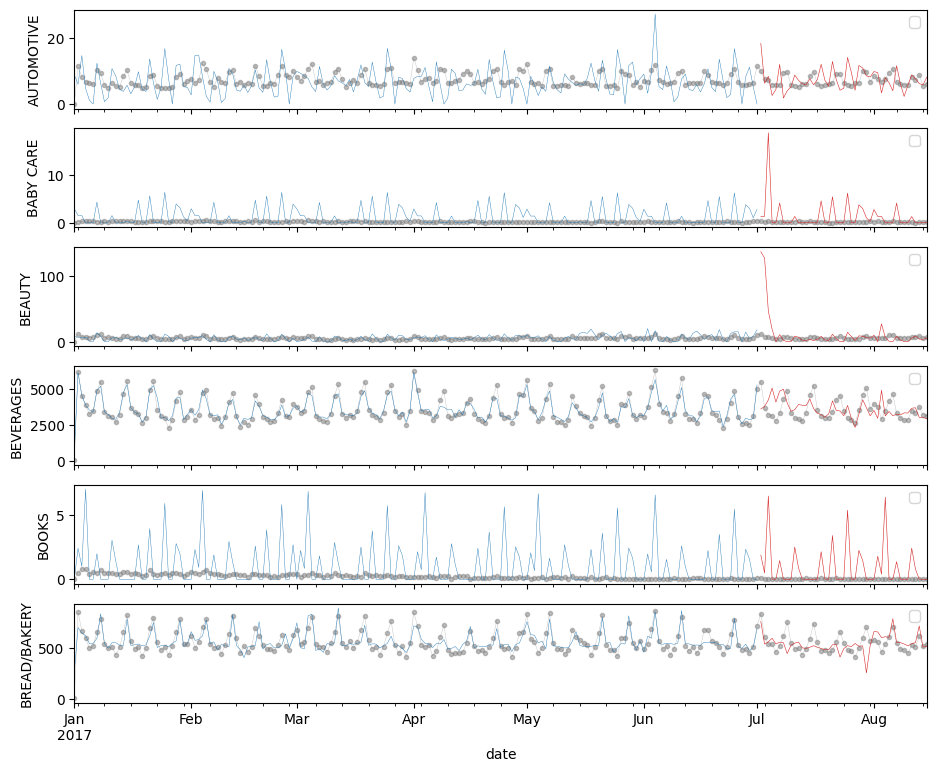

In [139]:
y_train, y_valid = y[:"2017-07-01"], y["2017-07-02":]
X1_train, X1_valid = X_1[: "2017-07-01"], X_1["2017-07-02" :]
X2_train, X2_valid = X_2.loc[:"2017-07-01"], X_2.loc["2017-07-02":]

# Some of the algorithms above do best with certain kinds of
# preprocessing on the features (like standardization), but this is
# just a demo.
model.fit(X1_train, X2_train, y_train)
y_fit = model.predict(X1_train, X2_train).clip(0.0)
y_pred = model.predict(X1_valid, X2_valid).clip(0.0)

families = y.columns[0:6]
axs = y.loc(axis=1)[families].plot(
    subplots=True, sharex=True, figsize=(11, 9), alpha=0.5, marker=".", color="grey", linewidth=0.3, grid="minor"
)
_ = y_fit.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C0', ax=axs, linewidth=0.3)
_ = y_pred.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C3', ax=axs, linewidth=0.4)
for ax, family in zip(axs, families):
    ax.legend([])
    ax.set_ylabel(family)

In [183]:
#bitwise operation
7 & 3

3

In [188]:
3 & 2

2

In [87]:
from enum import Flag, auto

class EventChannel(Flag):
    APP = auto()
    EMAIL = auto()
    PUSH = auto()
    ERROR = auto()

    NOTIFY = APP | EMAIL | PUSH

ec = EventChannel(7)
ec

<EventChannel.NOTIFY: 7>

In [60]:
ec & EventChannel(4)

<EventChannel.0: 0>

In [88]:
ec_app = EventChannel(1)
ec_email = EventChannel(2)
ec_notify = EventChannel(7)

In [91]:
(ec_app | ec_email | ec_notify)

<EventChannel.NOTIFY: 7>

In [83]:
test_channel = EventChannel(7)
test_channel

<EventChannel.NOTIFY: 7>

In [84]:
test_channel | ((ec_app | ec_email) & ec_both) == test_channel

True

In [ ]:
(00010 | 00001)